In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(os.pardir)
import vapor.helper as helper

# --- Load Dataframe ---
bnef = pd.read_csv(os.path.join('data','bnef','bnef_ppas_may_2020.csv'))

# --- Rename Column Names ---
bnef.columns = [c.lower().replace(' ','_')\
                         .replace('&','')\
                         .replace('__','_')\
                         .replace('(','')\
                         .replace(')','') for c in bnef.columns]

# --- Rename Columns ---
rename_dict = {
    'capacity_mw':'re_capacity_mw',
    'sector_subsector':'tech'
}
bnef = bnef.rename(rename_dict, axis='columns')

# --- Add Battery columns ---
bnef['batt_capacity_mw'] = 0
bnef['batt_capacity_mwh'] = 0

# --- clean tech ---
tech_dict = {
    'Wind, Onshore':'wind',
    'Solar, PV':'pv'
}
bnef['tech'] = bnef['tech'].map(tech_dict)

# --- Estimate last year ---
bnef['term'] = bnef['term'].fillna(15)
bnef['ppa_estimated_last_year'] = bnef['ppa_estimated_signing_year'] + bnef['term']


# --- Filter DF ---
bnef = bnef.loc[bnef['country'] == 'United States']
bnef = bnef.loc[bnef['tech'].isin(['pv','wind'])]
bnef = bnef.loc[bnef['ppa_estimated_last_year'] > 2020]
bnef = bnef.loc[bnef['re_capacity_mw'] > 0]
bnef = bnef.loc[~bnef['state'].isin(['Various','Hawaii','Alaska'])]

# --- Map on lon/lat ---
bnef['geocoder_lookup'] = bnef['country'] + ' ' + bnef['state'] + ' ' + bnef['project_name']
GeoCoder = helper.AddressToLonLatGeocoder()
GeoCoder.run(bnef['geocoder_lookup'])
bnef['lon_lat_tuple'] = bnef['geocoder_lookup'].map(GeoCoder.results_dict)
bnef['longitude'] = [i[0] if isinstance(i, tuple) else None for i in bnef['lon_lat_tuple']]
bnef['latitude'] = [i[1] if isinstance(i, tuple) else None for i in bnef['lon_lat_tuple']]
bnef = bnef.dropna(subset=['longitude','latitude'])
bnef


2020-08-19 06:31:26,364 [MainThread  ] [INFO ]  Starting log for vapor...
2020-08-19 06:31:26,446 [MainThread  ] [INFO ]  ....862 jobs found in cache, 0 still needed


,project_id,project_name,tech,structure,country,power_region,state,developer,offtaker,ppa_estimated_signing_year,term,re_capacity_mw,batt_capacity_mw,batt_capacity_mwh,ppa_estimated_last_year,geocoder_lookup,lon_lat_tuple,longitude,latitude
2,607,Somerset Wind Farm,wind,Not reported,United States,PJM,Pennsylvania,Community Energy Inc,Carnegie Mellon University,2001,20.0,4.5,0,0,2021.0,United States Pennsylvania Somerset Wind Farm,"(-78.79437109999999, 40.0436255)",-78.794371,40.043625
3,607,Somerset Wind Farm,wind,Not reported,United States,PJM,Pennsylvania,Community Energy Inc,Pennsylvania State University,2001,20.0,4.5,0,0,2021.0,United States Pennsylvania Somerset Wind Farm,"(-78.79437109999999, 40.0436255)",-78.794371,40.043625
6,1502,Rail Splitter Wind Farm,wind,Virtual PPA,United States,MISO,Illinois,Horizon Wind Energy,University of Illinois at Urbana-Champaign,2016,15.0,9.0,0,0,2031.0,United States Illinois Rail Splitter Wind Farm,"(-89.3985283, 40.6331249)",-89.398528,40.633125
10,2691,Spearville Wind Farm Phase I,wind,Virtual PPA,United States,SPP,Kansas,EDF Energy,Sprint Communications Inc,2006,15.0,10.0,0,0,2021.0,United States Kansas Spearville Wind Farm Phase I,"(-99.75274309999999, 37.8859387)",-99.752743,37.885939
23,4775,Notrees Wind Farm Phase I,wind,Physical PPA,United States,ERCOT,Texas,Tierra Energy LLC,NaN,2008,15.0,90.8,0,0,2023.0,United States Texas Notrees Wind Farm Phase I,"(-102.7557082, 31.9173411)",-102.755708,31.917341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,10000118,Inovateus Solar MSU PV Plant,pv,Not reported,United States,MISO,Michigan,Inovateus Solar LLC,Michigan State University,2020,10.0,23.5,0,0,2030.0,United States Michigan Inovateus Solar MSU PV ...,"(-84.4821719, 42.701848)",-84.482172,42.701848
1438,10000122,Clearway & Boston Scientific Massachusetts PV ...,pv,Virtual PPA,United States,New England,Massachusetts,Clearway Energy,Boston Scientific Corp,2020,20.0,54.6,0,0,2040.0,United States Massachusetts Clearway & Boston ...,"(-71.3824374, 42.4072107)",-71.382437,42.407211
1439,10000123,Clearway & Verizon Texas PV Plant Phase I,pv,Virtual PPA,United States,ERCOT,Texas,Clearway Energy,Verizon,2020,15.0,165.0,0,0,2035.0,United States Texas Clearway & Verizon Texas P...,"(-99.9018131, 31.9685988)",-99.901813,31.968599
1440,10000124,Clearway & Verizon Texas PV Plant Phase II,pv,Virtual PPA,United States,ERCOT,Texas,Clearway Energy,Verizon,2020,15.0,165.0,0,0,2035.0,United States Texas Clearway & Verizon Texas P...,"(-99.9018131, 31.9685988)",-99.901813,31.968599


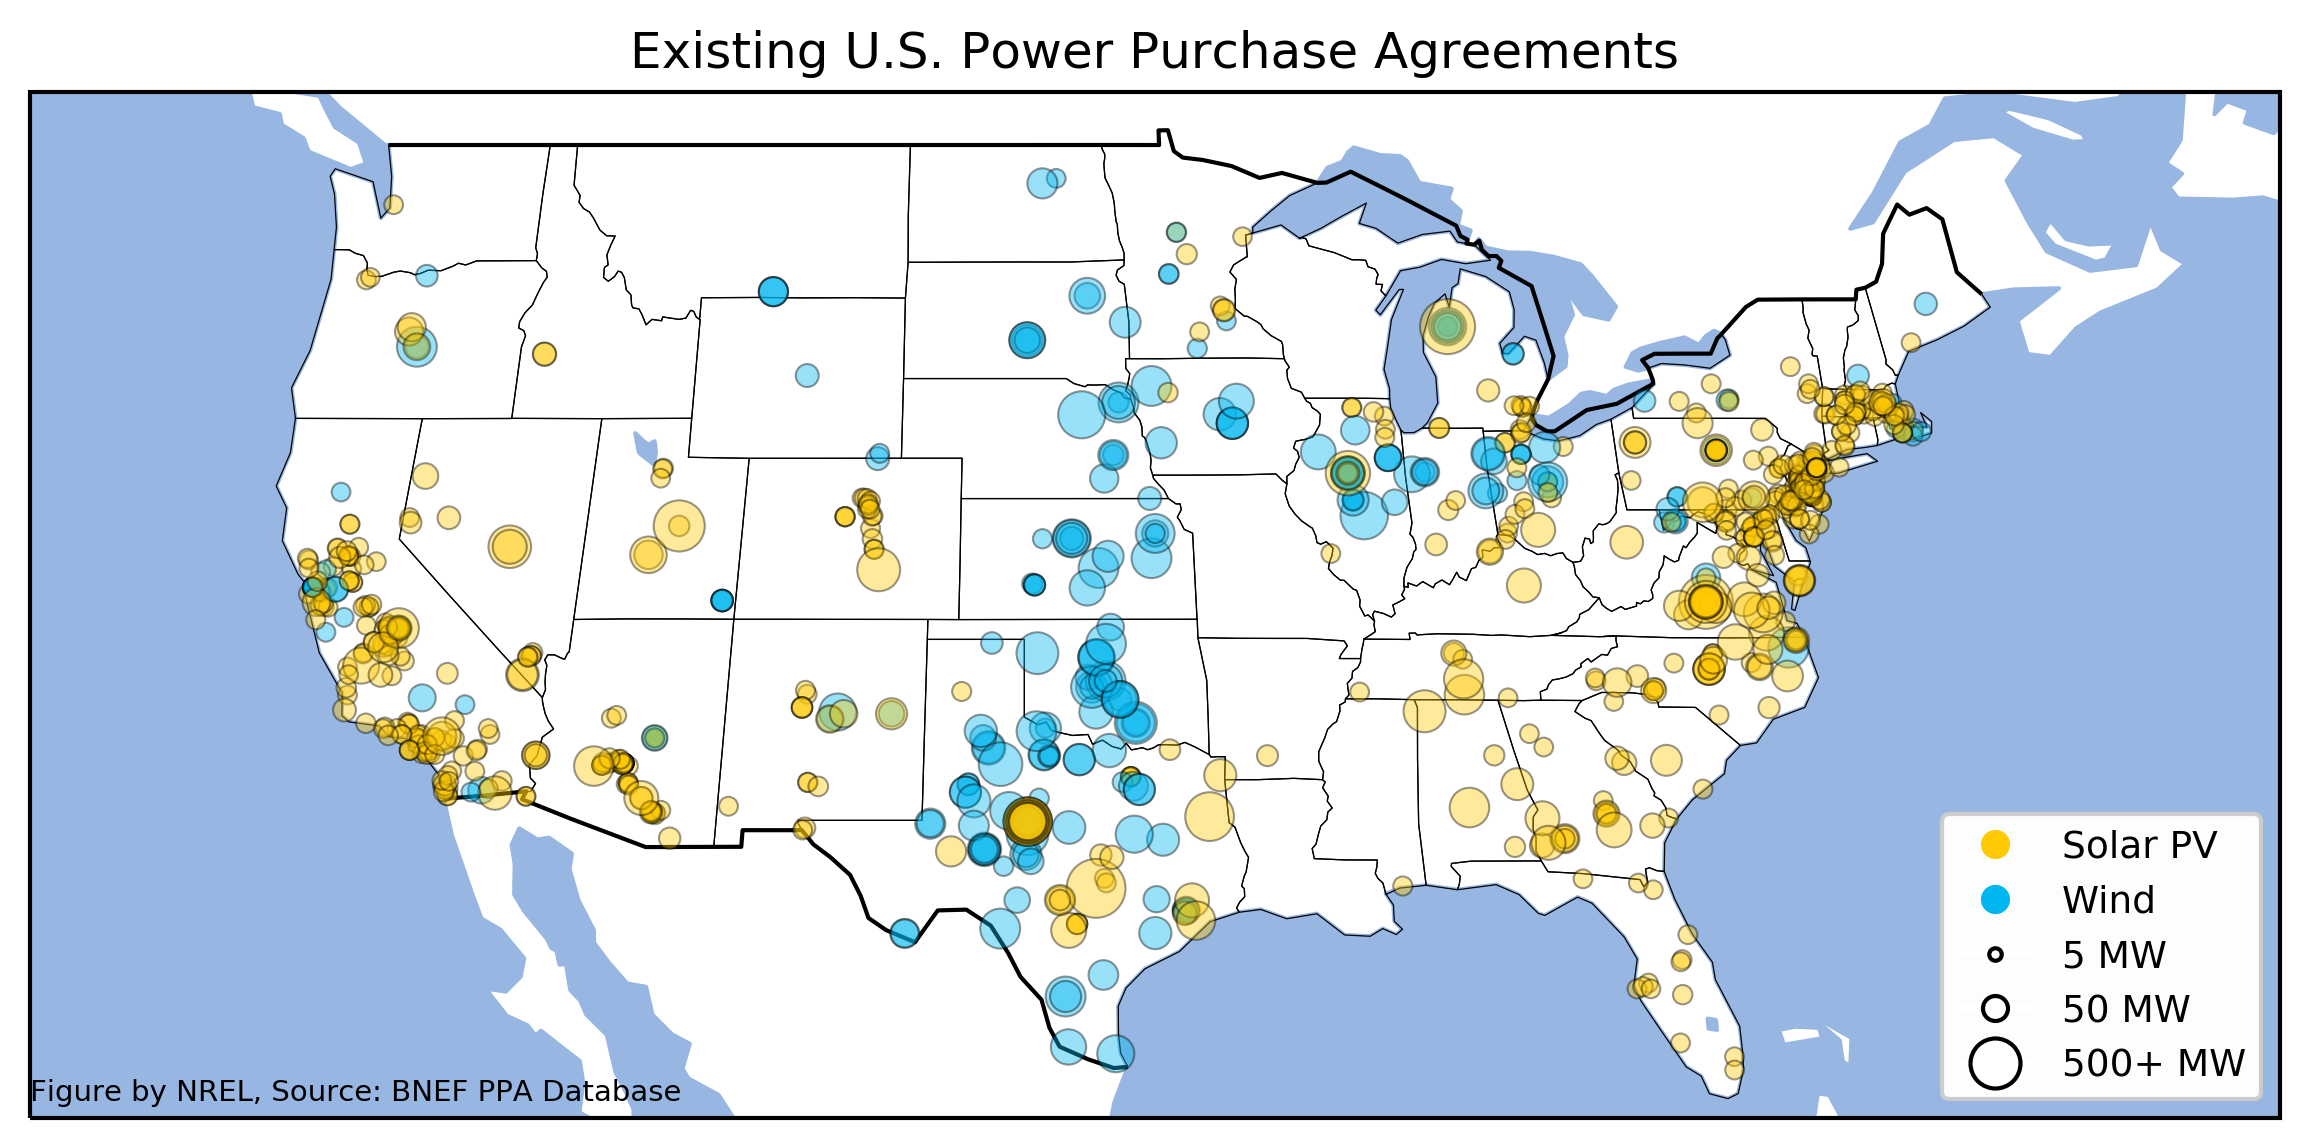

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import shapely

# --- Convert to geodataframe ---
bnef['geometry'] = [Point(row['longitude'], row['latitude']) for _, row in bnef.iterrows()]
bnef = gpd.GeoDataFrame(bnef)

# --- Get the geometry of the country ---
world_shape = gpd.read_file(os.path.join('data','geography','ne_110m_admin_0_countries','ne_110m_admin_0_countries.shp'))
country_shape = world_shape.loc[world_shape['ADMIN'] == 'United States of America']

# --- Get the geometry of the country ---
country_geo = country_shape['geometry'].item()

# --- Only take the biggest polygon (i.e. no alaska or hawaii for US) ---
if isinstance(country_geo, shapely.geometry.multipolygon.MultiPolygon):
    areas = [p.area for p in country_geo]
    biggest_area = max(areas)
    country_geo = [p for p in country_geo if p.area == biggest_area][0]

# --- Get bounds of largest polygon ---
bounds = country_geo.bounds

# --- Clean bounds ---
bounds = [round(i, 1) for i in bounds]
bounds = [bounds[0]*1.02, bounds[2]*0.98, bounds[1]*0.98, bounds[3]*1.02]

# --- Create Bubble Size Column ---
min_bubble_size = 20
max_bubble_size = 200
bnef['bubble_size'] = bnef['re_capacity_mw'].clip(upper=500)

def min_max_normalizer(val, old_min, old_max, new_min, new_max):
    return (new_max - new_min) / (old_max - old_min) * (val - old_max) + new_max

bnef['bubble_size'] = np.vectorize(min_max_normalizer)(bnef['bubble_size'],
                                                       min(bnef['bubble_size']),
                                                       max(bnef['bubble_size']),
                                                       min_bubble_size,
                                                       max_bubble_size)

bubble_size_5mw = min_max_normalizer(5, min(bnef['bubble_size']), max(bnef['bubble_size']), min_bubble_size, max_bubble_size)
bubble_size_50mw = min_max_normalizer(50, min(bnef['bubble_size']), max(bnef['bubble_size']), min_bubble_size, max_bubble_size)
bubble_size_500mw = min_max_normalizer(500, min(bnef['bubble_size']), max(bnef['bubble_size']), min_bubble_size, max_bubble_size)

# --- Map hex colors ---
cmap= {
       'pv':'#FFC903',
       'wind':'#00B6EF',
    }

bnef['color'] = bnef['tech'].map(cmap)

# --- Initialize crs ---
crs = ccrs.InterruptedGoodeHomolosine()
bnef.crs = 'EPSG:4326'
bnef = bnef.to_crs(crs.proj4_init)

# --- Initialize Figure ---
fig = plt.figure(figsize=(7.5, 5), dpi=300)
ax = fig.add_axes([0, 0, 1, 1], projection=crs)
ax.set_extent(bounds, ccrs.PlateCarree())

# --- Plot ---
bnef.plot(ax=ax, color=bnef['color'], markersize='bubble_size', edgecolor='k', linewidth=0.5, alpha=0.4, zorder=100)

# --- Create legend ---
colormarklist = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in list(cmap.values())]
colormarklabels = ['Solar PV', 'Wind']

mark5 = plt.Line2D([0,0],[0,0], color="white", marker='o', markersize=3, markerfacecolor="white", markeredgecolor = 'black')
mark50 = plt.Line2D([0,0],[0,0], color="white", marker='o',markersize=6, markerfacecolor="white", markeredgecolor = 'black')
mark500 = plt.Line2D([0,0],[0,0], color="white", marker='o', markersize=12, markerfacecolor="white", markeredgecolor = 'black')
marklist = [mark5,mark50,mark500]
marklabellist = ['5 MW','50 MW','500+ MW']
    
allmark = colormarklist + marklist
allmarklabel = colormarklabels + marklabellist

plt.legend(allmark,
           allmarklabel,
           framealpha=0.98,
           numpoints=1,
           loc='lower right',
           fontsize=9)

fig.text(0, 0.17, 'Figure by NREL, Source: BNEF PPA Database', size=7)

# --- Create Title ---
ax.set_title(f'Existing U.S. Power Purchase Agreements')
                  
# --- Make Pretty Background ---
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 5)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES, linewidth=0.3)
ax.add_feature(cfeature.BORDERS)

plt.show()


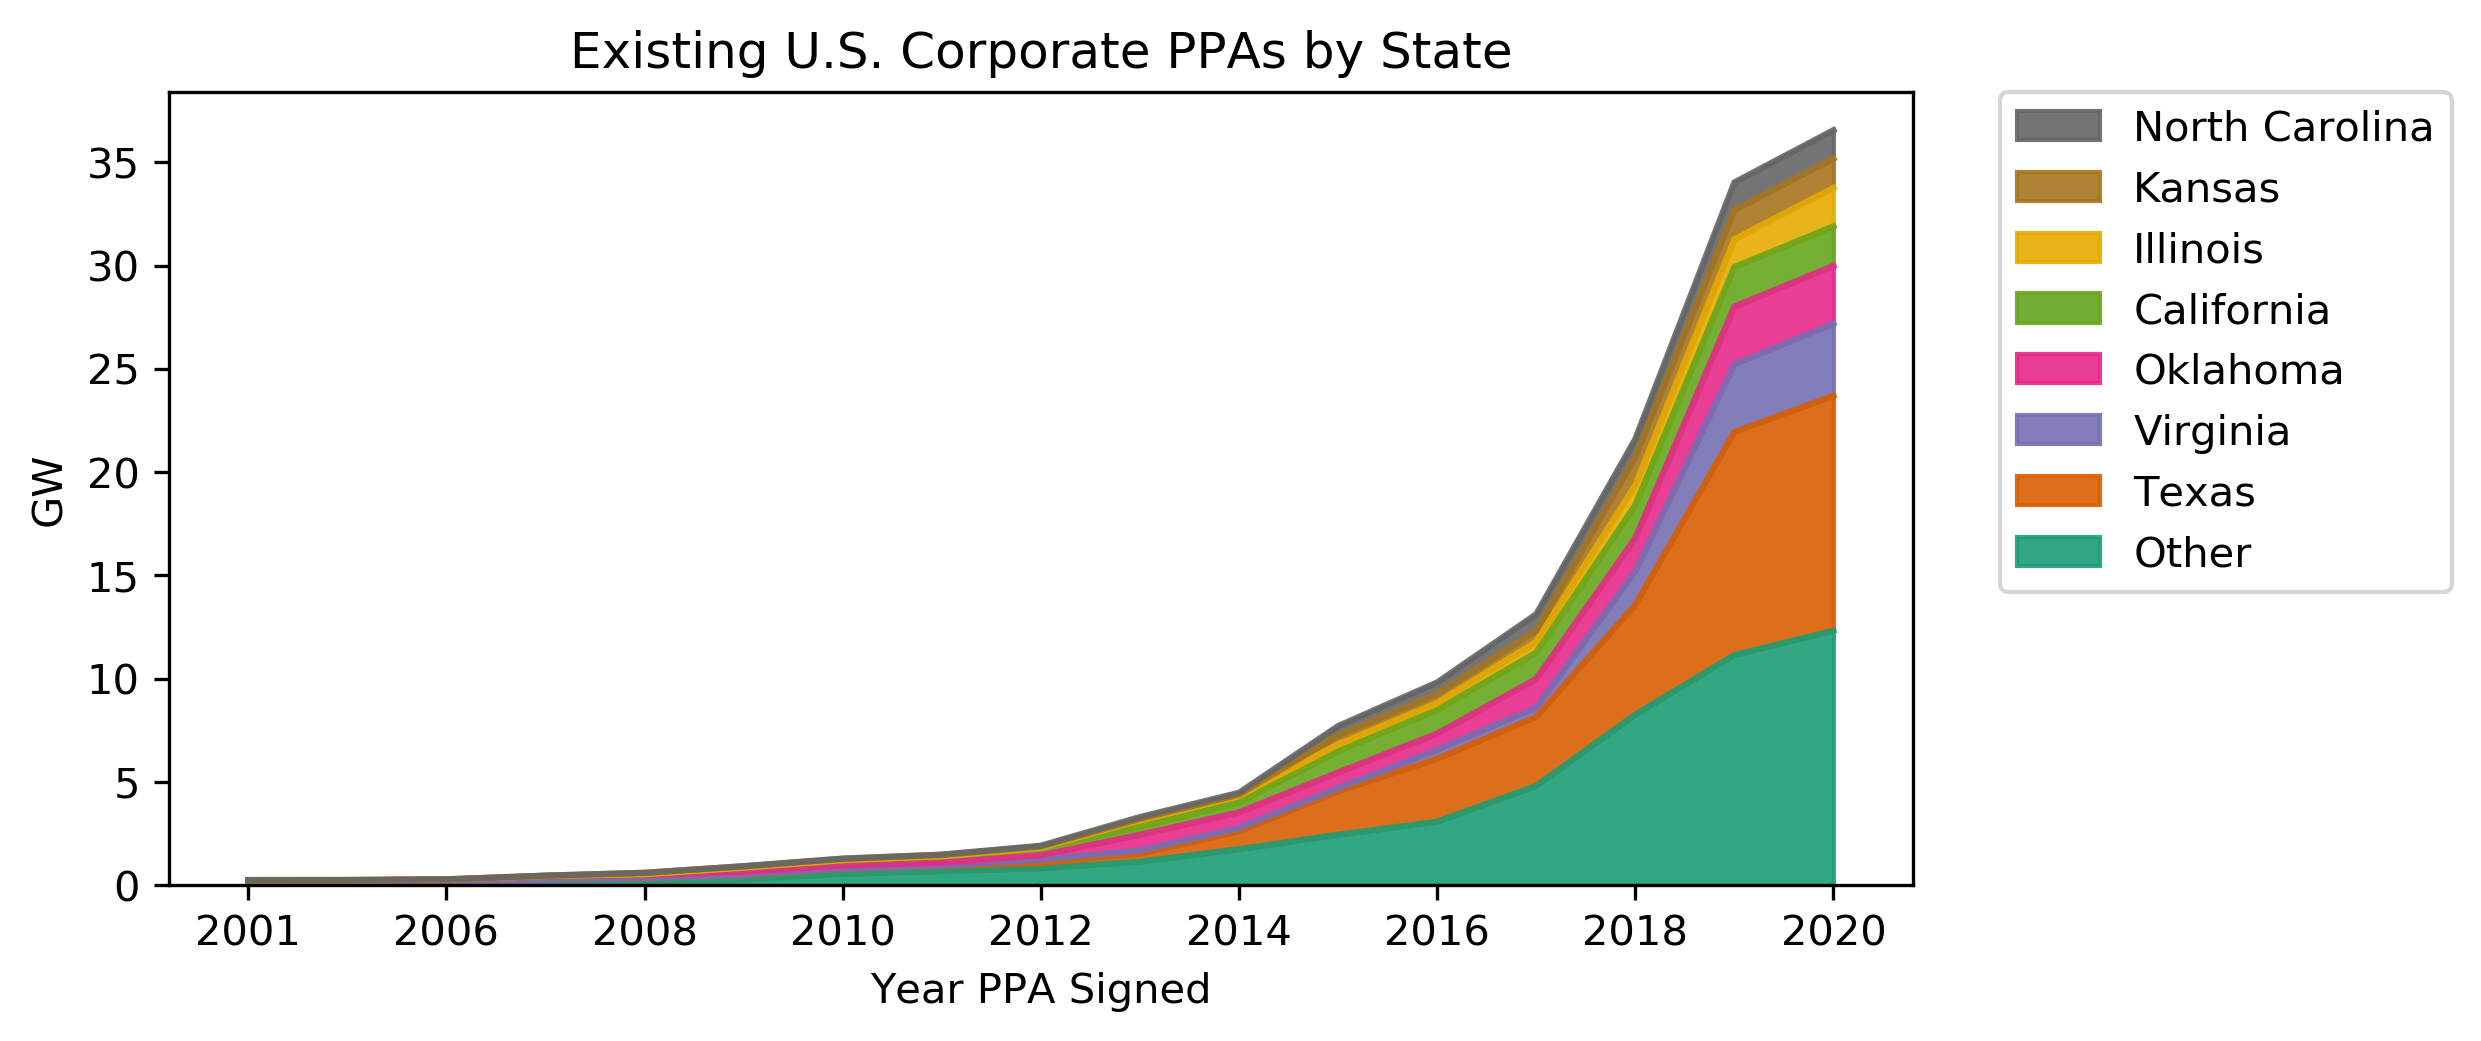

In [3]:
import seaborn as sns

# --- Create Column with state name if in top 10 ---
top_states = list(bnef.groupby('state')['re_capacity_mw'].sum().sort_values(ascending=False)[0:7].index)
bnef['top_states'] = [s if s in top_states else 'Other' for s in bnef['state']]

# --- Groupby ---
grouped = bnef.groupby(['top_states','ppa_estimated_signing_year'], as_index=False)['re_capacity_mw'].sum()
grouped.sort_values(['top_states','ppa_estimated_signing_year'], inplace=True)
grouped['cumulative_mw'] = grouped.groupby(['top_states'])['re_capacity_mw'].transform(lambda x: x.cumsum())
grouped['ppa_estimated_signing_year'] = grouped['ppa_estimated_signing_year'].astype(str)

# --- Make Wide ---
wide = grouped.pivot(index='ppa_estimated_signing_year', columns='top_states', values='cumulative_mw')
wide = wide.fillna(method='bfill').fillna(method='ffill')
wide = wide / 1000

# --- Sort by columns ---
wide.sort_values('2020', axis=1, ascending=False, inplace=True)

# --- Initialize Figure ---
fig, ax = plt.subplots(figsize=(7.5, 3.5), dpi=300)
sns.set_style()

# --- Plot ---
wide.plot.area(ax=ax, colormap='Dark2', alpha=0.9)

# --- Style ---
ax.set_xlabel('Year PPA Signed')
ax.set_ylabel('GW')
ax.set_title('Existing U.S. Corporate PPAs by State')


# --- Legend ---
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [4]:
import vapor 
vapor.config.BAYES_INIT_POINTS = 0
vapor.config.BAYES_ITER = 0

# --- Initialize Pipeline ---
existing_plumbing = vapor.ExistingPipeline(
             aggregate_region='pca')

# --- Execute Simulations ---
existing_plumbing.setup(df=bnef)

# --- Match Lon/Lat to Resource Region ---
bnef = existing_plumbing.fetch_resource(bnef)

opt_vars = ['lcoe_nom']

existing_plumbing.run(df=bnef, opt_vars=opt_vars)

# --- Get Best Systems ---
existing_best = existing_plumbing.best_systems

existing_best.to_pickle('bnef_results.pkl')

2020-08-19 06:31:30,843 [MainThread  ] [INFO ]  

2020-08-19 06:31:30,844 [MainThread  ] [INFO ]  Loading cambium data from pickle
/home/skoebric/anaconda2/envs/ml/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!(EPSG:4326 != {'init': 'epsg:4326'})
  warn(
2020-08-19 06:32:47,254 [MainThread  ] [INFO ]  Beginning data download for wind using 20 thread workers
2020-08-19 06:32:47,264 [MainThread  ] [INFO ]  ....finished data download
2020-08-19 06:32:47,275 [MainThread  ] [INFO ]  Beginning data download for pv using 20 thread workers
2020-08-19 06:32:47,284 [MainThread  ] [INFO ]  ....finished data download
2020-08-19 07:06:50,901 [MainThread  ] [INFO ]  ........finished optimizing job 97 / 975 21.07 s/j ETA: 5.138278087310638
2020-08-19 07:41:55,113 [MainThread  ] [INFO ]  ........finished optimizing job 194 / 975 21.38 s/j ETA: 4.63838315068344
2020-08-19 08:18:26,981 [MainThread  ] [INFO ]  ........finished optimizing j

MemoryError: 

In [ ]:
existing_plumbing.best_systems